In [2]:
import pandas as pd
import requests
import re
import time
import numpy
import matplotlib.pyplot as plt
from matplotlib import colors
from bs4 import BeautifulSoup
import json
import sys
import warnings
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_columns", 200)
pd.reset_option("display.max_columns")


For us to properly save the JSON results when scraping the internal bee.deals API, we set up a function to flatten the hierarchical JSON structure. We'll get rid of unneeded column prefixes along the way.

In [3]:
def normalize_json_result(result):#flatten JSON structure, remove unneeded column prefixes
    normalized = pd.json_normalize(result)
    normalized.columns = normalized.columns.str.replace(r'targetData.', '')    
    with open('results.csv', 'a') as f:
        normalized.to_csv(f, header=f.tell()==0)
    return normalized

Query the backend while consequitevily increasing the page parameter until all pages are fetched. HTTP headers are set in order to somewhat impersonate the frontend and a two seconds sleep is set after each iteration in order to not overwhelm the backend with requests

In [6]:
page_idx = 1
normalized_json_results = [] #after flattening the json structure, collect the results in list
while True:
    try:
        url = 'https://il.bee.deals/services/dealService/browseNewsfeedDeals?groupId=false&hotDeals=0&limit=50&newDeals=0&news=0&page='+str(page_idx)+'&personalFeed=false&publisherId=0&userBought=0&userId=false&userLoves=0&userSaved=0&usersAsk=0'
        headers = {'authority': 'il.bee.deals', 'pragma': 'no-cache', 'cache-control': 'no-cache', 'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="90", "Google Chrome";v="90"', 'accept': 'application/json, text/plain, */*', 'sec-ch-ua-mobile': '?0', 'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36', 'sec-fetch-site': 'same-origin', 'sec-fetch-mode': 'cors', 'sec-fetch-dest': 'empty', 'referer': 'https://il.bee.deals/dashboard', 'accept-language': 'en-US,en;q=0.9,he;q=0.8,ru;q=0.7'}
        response = requests.get(url, headers=headers)
        res = response.json()
        if not res or not res['cnt']:
            break
        normalized_json_results.append(normalize_json_result(res['result']))
        print(f"fetching results for page {page_idx}...")
        page_idx += 1
        time.sleep(2)#not to overwhelm the backend...
    except:
        print("Oops!", sys.exc_info()[0], "occurred.")

fetching results for page 1...
fetching results for page 2...
fetching results for page 3...
fetching results for page 4...
fetching results for page 5...
fetching results for page 6...
fetching results for page 7...
fetching results for page 8...
fetching results for page 9...
And so on...


In [8]:
rr = []
for r in normalized_json_results:
    rc = r.copy()
    rc = rc.loc[:,~rc.columns.duplicated()] #remove duplicate columns from the flattened JSON results
    rr.append(rc) #add to list which will be converted to a DataFrame

Concatenate everything into a DataFrame

In [44]:
df = pd.concat(rr, ignore_index=True)
df.shape

(67174, 255)

Removing unneeded Currency columns

In [45]:
cols_to_drop = []
for col in df.columns:
    if re.match(r"localShippingCurrency\.[A-Z]{3}.*", col) or re.match(r"localCurrency\.[A-Z]{3}.*", col):
        cols_to_drop.append(col) if col not in cols_to_drop else cols_to_drop
df.drop(columns=cols_to_drop, inplace=True)

Removing string content from User.rank column, convert relevant columns to Numeric type

In [115]:
dfc = df.copy()
dfc['user.rank'] = dfc['user.rank'].str.replace(r'\D+', '')
cols = ["user.followers", "user.follows", "user.deals_count", "user.loves_count", "user.rep", "user.sex", "user.isAdmin", "store.store_id", "price", "shippingPrice", "loves", "unloves", "boughts", "comments", "clicks", "impressions", "localCurrency.current_exchange_rate", "localShippingCurrency.current_exchange_rate", 'user.rank']

dfc[cols] = dfc[cols].apply(pd.to_numeric)
dfc.head(100)

,Unnamed: 0,ago,id,type,newsfeed,highlight,internal,tags_cat_id,group_id,duplicateDeal,date,last_edit_date,last_update_date,convs,uniqueUserDeal,currency,user.id,user.username,user.pic_cover,user.pic_cover_offset_x,user.pic_cover_offset_y,user.pic_small,user.pic,user.pic_big,user.first_name,user.last_name,user.followers,user.follows,user.deals_count,user.loves_count,user.rep,user.rank,user.sex,user.blocked,user.website,user.about_me,user.isAdmin,store.store_id,store.title,store.title_he,store.domain,...,video_swf,loves,unloves,boughts,comments,country,sex,clicks,impressions,rev,cost,user_cost,locked,expired,expired_users,newTitle,rank,noUrl,timed,edit_ago,alphaId,tags,loved,bought,saved,following,category,localPrice,localCurrency.id,localCurrency.iso,localCurrency.title,localCurrency.symbol,localCurrency.current_exchange_rate,localShippingPrice,localShippingCurrency.id,localShippingCurrency.iso,localShippingCurrency.title,localShippingCurrency.symbol,localShippingCurrency.current_exchange_rate,user,localCurrency
0,0,10/06/2021 14:22,81192,1,1,0,0,23504.0,0,0,2021-06-10 14:22:44,2021-06-10 14:49:20,2021-06-17 18:45:17,0,05659cd5c452841429b8cc83b7a6277e,ILS,15964.0,david6,NaN,NaN,NaN,https://lh5.googleusercontent.com/-0Jq6wnHL8rM/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucnP5M59PwQcFaFDVjA6KvB9xlz6Xg/photo.jpg,https://lh5.googleusercontent.com/-0Jq6wnHL8rM/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucnP5M59PwQcFaFDVjA6KvB9xlz6Xg/photo.jpg,https://lh5.googleusercontent.com/-0Jq6wnHL8rM/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucnP5M59PwQcFaFDVjA6KvB9xlz6Xg/photo.jpg,דודי,עטיה,3.0,0.0,9.0,21.0,51.25,2.0,0.0,0.0,NaN,NaN,0.0,2735,Leumi,NaN,leumi.co.il,...,0,3,0,0,21,IL,0.0,26,760,0.0,0.0,0.0,0,0,NaN,1,39,0,221:09:01,10/06/2021 14:49,3Z3bbbc,[],False,False,False,False,False,10.0,7.0,ILS,שקל חדש,₪,3.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,לפני יומיים,81362,1,1,0,0,0.0,0,0,2021-06-17 18:32:58,NaN,2021-06-17 18:32:58,0,a3c45e5a7dc7a9e1ed10b2f0a0965a0b,ILS,16796.0,יאפ,NaN,NaN,NaN,https://lh3.googleusercontent.com/-PLiDKdKJTu4/AAAAAAAAAAI/AAAAAAAAAAA/AMZuuclb3AItUqcjaphizsYtHYaoUUNCRg/photo.jpg,https://lh3.googleusercontent.com/-PLiDKdKJTu4/AAAAAAAAAAI/AAAAAAAAAAA/AMZuuclb3AItUqcjaphizsYtHYaoUUNCRg/photo.jpg,https://lh3.googleusercontent.com/-PLiDKdKJTu4/AAAAAAAAAAI/AAAAAAAAAAA/AMZuuclb3AItUqcjaphizsYtHYaoUUNCRg/photo.jpg,יאפ,פאי,1.0,0.0,2.0,43.0,37.25,2.0,0.0,0.0,NaN,NaN,0.0,6179,Laken,NaN,laken.co.il,...,0,4,0,0,0,IL,0.0,27,194,0.0,0.0,0.0,0,0,NaN,1,7,0,48:58:47,False,2d4bbbc,[],False,False,False,False,False,69.0,7.0,ILS,שקל חדש,₪,3.28,15.0,7.0,ILS,שקל חדש,₪,3.28,NaN,NaN
2,2,13/06/2021 07:46,81246,1,1,0,0,0.0,0,0,2021-06-13 07:46:43,NaN,2021-06-17 18:22:16,0,1454f186ac296c5aaa742eff28e34f56,ILS,11353.0,ZeevCo,NaN,NaN,NaN,https://il.bee.deals/static/uploads/d04a6b3f6bba935f2aea04bec90a101e_thumb.jpg,https://il.bee.deals/static/uploads/d04a6b3f6bba935f2aea04bec90a101e_thumb100.jpg,https://il.bee.deals/static/uploads/d04a6b3f6bba935f2aea04bec90a101e.jpg,Zeev,Co.,92.0,5.0,689.0,441.0,6533.00,9.0,0.0,0.0,NaN,NaN,0.0,3086,Azrielimalls,NaN,azrielimalls.co.il,...,0,3,0,2,17,IL,0.0,183,1001,0.0,0.0,0.0,0,0,NaN,1,58,0,155:45:02,False,0b4bbbc,[],False,False,False,False,False,0.0,7.0,ILS,שקל חדש,₪,3.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,16/06/2021 15:37,81332,1,1,0,0,21397.0,0,0,2021-06-16 15:37:26,NaN,2021-06-17 18:14:53,0,aebf1263ffedbc2fa76c043c61477a62,ILS,13429.0,אני2,NaN,NaN,NaN,https://il.bee.deals/static/uploads/3a52dbb3a61ab292e904ece48fbe0e44_thumb.jpg,https://il.bee.deals/static/uploads/3a52dbb3a61ab292e904ece48fbe0e44_thumb100.jpg,https://il.bee.deals/static/uploads/3a52dbb3a61ab292e904ece48fbe0e44.jpg,אני,אני,33.0,1.0,210.0,1044.0,3569.75,9.0,1.0,0.0,NaN,NaN,0.0,5154,Darlain,NaN,darlain.co.il,...,0,7,0,1,4,IL,1.0,58,233,0.0,0.0,0.0,0,0,NaN,1,16,0,75:54:19,False,Tc4bbbc,[],False,False,False,False,False,0.0,7.0,ILS,שקל חדש,₪,3.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,14/06/2021 22:14,81285,1,1,0,0,0.0,0,72959,2021-06-14 22:14:33,2021-06-17 17:04:41,2021-06-17 18:09:00,0,94eb8cb4a

In [205]:
user_cols=['user.follows', 'user.deals_count', 'user.loves_count', 'user.rep', 'user.rank']
dfc[user_cols].isna().sum()


user.follows        368
user.deals_count    368
user.loves_count    368
user.rep            368
user.rank             0
dtype: int64

Some user columns contain NaN values. Let's fill them with the median for the respective column. 
For other (non-user) columns, we'll fill NaN with 0.

In [25]:
def fill_nan_values(df, user_cols=user_cols):
    dfc = df.copy()
    for user_col in user_cols:
        dfc[user_col].fillna(df[user_col].median(), inplace=True)
    dfc.fillna(0, inplace=True)
    return dfc

In [51]:
dfc = fill_nan_values(dfc)

In [64]:
dfc[user_cols].isna().sum()

user.followers      0
user.follows        0
user.deals_count    0
user.loves_count    0
user.rep            0
user.rank           0
dtype: int64

converting user columns to Integer type

In [78]:
for user_col in user_cols:
    dfc[user_col] = dfc[user_col].astype(int)

In [119]:
#since new posts can be added while crawling, paged API results might contain duplicate rows - let's get rid of them
dfc = dfc[~dfc.duplicated('id')]
dfc.shape


(67327, 95)

Adding extra columns by converting all prices in local currencies to US dollars

In [129]:
dfc['price_in_usd'] = dfc['localPrice']/dfc['localCurrency.current_exchange_rate']
dfc['shipping_price_in_usd'] = dfc['localShippingPrice']/dfc['localShippingCurrency.current_exchange_rate']
dfc['shipping_price_in_usd'].fillna(value=0, inplace=True)
dfc['total_price_in_usd']= dfc['price_in_usd'] + dfc['shipping_price_in_usd']
dfc['total_price_in_usd'].fillna(value=0, inplace=True)

Adding a column which holds amount of words in item description. We'll strip HTML tags first, in order for the tags not to count as words

In [113]:
def text_from_html(html):
    with warnings.catch_warnings(): #BeautifulSoup displays warnings when HTML to be parsed includes links, we have no use for those
        warnings.simplefilter("ignore")
        soup = BeautifulSoup(html, features="html.parser")
        text = soup.get_text()
    return text
   
def word_count_from_text(text):
    return len(text.split())

def word_count_from_html(html):
    text = text_from_html(html)
    return word_count_from_text(text)
    
dfc['desc_word_count']= dfc['description'].apply(lambda d: word_count_from_html(d))

Adding a column counting how many images the user added to his post

In [74]:
dfc['imgs_count'] = dfc['imgs'].apply(lambda imgs_str: len(json.loads(imgs_str)))
dfc['imgs_count'].describe()

count    67327.000000
mean         2.043608
std          1.715100
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max         83.000000
Name: imgs_count, dtype: float64

Adding sentiment scores for item descriptions - first we need to translate those description to English

In [21]:
!{sys.executable} -m pip install google_trans_new

from google_trans_new import google_translator  

In [22]:
dfc["desc_eng"] = numpy.nan

In [24]:
proxies = {}#1.1.1.2, 1.1.1.2... check out webshare.io for free proxies
translator = google_translator(timeout=5, proxies=proxies)
def translate_description_from_heb(row):
    try:
        print(f'translating sentence {row.name}')
        
        return translator.translate(row.description, lang_src='he', lang_tgt='en')
    except Exception as e:
        print("Oops!", sys.exc_info()[0], "occurred.")
        print(e)
        return ''
dfc['desc_eng'] = dfc.apply(lambda row: translate_description_from_heb(row), axis=1)

translating sentence 0
translating sentence 1
translating sentence 2
translating sentence 3
translating sentence 4
translating sentence 5
translating sentence 6
translating sentence 7
translating sentence 8
translating sentence 9
And so on...


In [28]:
dfc["desc_eng_suppl"] = numpy.nan

In [26]:
def supplement_transl_for_row(row):
    print(f'working on {row.name}')
    if len(row.desc_eng) > 0:
        print('translation present!')
        return row.desc_eng
    else:
        print('fetching translation...')
        return translate_from_heb(row.description)
dfc['desc_eng_suppl'] = dfc.head(10).apply(lambda row: supplement_transl_for_row(row), axis=1)


working on 0
translation present!
working on 1
translation present!
working on 2
translation present!
working on 3
translation present!
working on 4
translation present!
working on 5
translation present!
working on 6
translation present!
working on 7
translation present!
working on 8
translation present!
working on 9
translation present!


In [37]:
dfc['desc_eng_suppl_plaintext']= dfc['desc_eng_suppl'].apply(lambda html: text_from_html(html))

Now that we have all the translations, we can analyze the sentiment of item descriptions

In [80]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /Users/b/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
def sentiment_scores(sentence):
    return sid.polarity_scores(sentence)
dfc['desc_sentiment']= dfc['desc_eng_suppl_plaintext'].apply(lambda d: sentiment_scores(d))

In [46]:
dfc = dfc.join(pd.json_normalize(dfc['desc_sentiment']))
dfc.columns

Index(['ago', 'id', 'type', 'newsfeed', 'highlight', 'internal', 'tags_cat_id',
       'group_id', 'duplicateDeal', 'date',
       ...
       'desc_word_count', 'imgs_count', 'desc_eng', 'desc_eng_suppl',
       'desc_eng_suppl_plaintext', 'desc_sentiment', 'neg', 'neu', 'pos',
       'compound'],
      dtype='object', length=108)

The sentiment scores have been added and we split the sentiment dictionary into separate columns. We'll rename them for convenience

In [51]:
dfc.rename(inplace=True, columns={"neg": "desc_sentiment_neg", "neu": "desc_sentiment_neu", "pos": "desc_sentiment_pos", "compound": "desc_sentiment_compound"})

In [108]:
dfc[['description','desc_eng_suppl']].head(100)

,description,desc_eng_suppl
0,"לאומי הודיעו שחודש הבא יתקיים מבצע קיץ ב10 <br>קיץ שעבר ובחורף היה מלא הטבות ממש שוות ב10 ש""ח ו10 גודיז <br>למי שיש כרטיס אשראי שלהם מומלץ להשתמש בעיקר בו החודש, נותרו 15 יום לצבירת גודיז לחודש הב...","Leumi announced that the next month will take place for summer at 10, and in the winter, it was full of quite equal benefits in 10 NIS and 10 Goods, for those who have their credit card recommende..."
1,"750 מ""ל, תרמי מהסדרה הגבוהה.<br>מניסיון של 3 בקבוקים בבית במהלך 6 שנים - הבקבוקים שלהם מעולים, שומרים שעות רבות גם על חום וגם על קור.<br>לא נוזלים (פתיחת הברגה).<br>תוצרת ספרד, נירוסטה בדרגת מזון,...","750 ml, thermal from the high series. <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br..."
2,"Azrieli Days - קופוני הנחה לחנויות הקניון<br>באפליקצית עזריאלי<br>ראשון עד מוצ""ש בין התאריכים 13-19.6.21",Azrieli Days - Discount coupons for shopping shops <br> Azrieli Appelicism
3,"דארלן - 60% הנחה + 10% הנחה נוספת על כל האתר עד יום שבת (10% הנחה נוספת בתוקף עד ה- 19/6).<br><br>• משלוח חינם בקנייה מעל 199 ש''ח<br><br>אני מכירה ועוקבת אחר המחירים שלהם שאף פעם לא משתנים, ה- 60...",Darlene - 60% OFF + 10% Another discount on the entire site until Saturday (10% Another discount in force until 19/6). <br> <br> <br> <br> <br> <br> <br> Br> I know and follow their prices that ha...
4,"מחיר מצויין ודיל פ-י-ג-ו-ז על כונן קשיח *חיצוני* תוצרת Western Digital מדגם Elements, נפח 4TB, ב- 389 ש""ח ב- KSP.<br>(מספר דגם: WDBU6Y0040BBK).<br>אאלט, זה המחיר הכי זול שאני זוכר לכונן הזה - 389 ...","Excellent price and weddewd F-J-G-G-m Hard Drive * External * Made in Western Digital Sample Elements, 4TB volume, NIS 389 in KSP. <br> (Model Number: WdBu6Y0040BBK). <br> Ealt, this is the cheape..."
5,Normal Price: $32.99<br>Coupon Price: $12.99<br>Coupon: BGis691<br>Warehouse: CN<br>EXP: 07.31<br>Best price and free shipping!<br><br>Feature :<br> <br>- Display mode :<br>DP-2 : Time/Temperature...,"Normal Price: $ 32.99 <br> Coupon Price: $ 12.99 <br>Coupon: Bgis691 <br> Warehouse: CN <br> 07.31 <br> Best Price and Free Shipping! Br> - Display Mode: <br> DP-2: Time / Temperature, HumyDity, 2..."
6,כסא בטיחות שוקלים לקנות.<br>מה אתם אומרים?,The safety chair are considering buying. <br> What do you say?
7,"עריכה - באפליקציה בלבד: אסוס טורקיה, רובל, קוד LOVEAPP ביציאה.<br>100 אחוז כותנה.<br><br>למי שלא מכיר: Schott היא חברה ניו-יורקית איכותית מאוד, בת יותר ממאה שנה. היא זו שהמציאה את מעיל האופנוענים ...","Editing - application only: Asus Turkey, Ruble, LoveApp Code. <br> 100 percent cotton. <br> <br> For those who do not know: Schott is a very high quality New York company, more than 100 years old...."
8,בקבוק פפסי מקס דובדבן החדש מתנה<br>0.5 ליטר<br>למימוש ברשתות רמי לוי יינות ביתן מגה שוק העיר מחסני השוק<br>בתוקף עד 10.8.21<br><br>מצרף בתגובה הראשונה את הקופון<br><br>לקחתם תנו בלייק :thumbsup:,Bottle Pepsi Max Cherry New Gift <br> 0.5 Liter <br> Rami Levy Wines Wines Mega City Market Stanes Only Up to 10.8.21 <br> <br> Additional Incoming Coupon Take them Blake: Thumbsup:
9,קוד 5723998<br>בחודש יוני<br><br>https://i.imgur.com/N2780DK.png,Code 5723998 <br> in June <br> <br> https://i.imgur.com/n2780dk.png


Converting user.blocked column...

In [138]:
dfc = dfc.astype({'user.blocked': 'float'})

Adding a column to count amount of words in post title

In [139]:
dfc['title_word_count']= dfc['titleIL'].apply(lambda d: word_count_from_html(d))

Adding a column to mark free shipment

In [140]:
dfc['free_shipping'] = dfc.shipping_price_in_usd.apply(lambda p: 1 if p == 0 else 0)

Adding a column to mark items shipped locally from Israel, after some manipulation on the store.domain column

In [141]:
dfc.rename(columns={'store.domain': 'store_domain'}, inplace=True)

dfc.store_domain = dfc.store_domain.astype(str)


In [142]:
dfc['shipping_from_il'] = dfc.store_domain.apply(lambda d: 1 if d.endswith('.il') else 0)

In [143]:
dfc[["shipping_price_in_usd", "free_shipping", 'store_domain', 'shipping_from_il']].head(20)

,shipping_price_in_usd,free_shipping,store_domain,shipping_from_il
0,0.000000,1,leumi.co.il,1
1,4.573171,0,laken.co.il,1
2,0.000000,1,azrielimalls.co.il,1
3,0.000000,1,darlain.co.il,1
4,0.000000,1,ksp.co.il,1
5,0.000000,1,banggood.com,0
6,0.000000,1,agalease-baby.co.il,1
7,0.000000,1,asos.com,0
8,0.000000,1,pepsimax.co.il,1
9,0.000000,1,ace.co.il,1


Remove internal/unnecessary columns:

In [144]:
dfc = dfc[['user.follows', 'user.deals_count', 'user.loves_count', 'user.rep', 'user.rank', 'user.blocked', 'user.isAdmin', 'loves', 'unloves', 'boughts', 'comments', 'clicks', 'impressions', 'desc_word_count', 'imgs_count', 'desc_sentiment_neg', 'desc_sentiment_neu', 'desc_sentiment_pos', 'desc_sentiment_compound', 'free_shipping', 'shipping_from_il', 'price_in_usd', 'shipping_price_in_usd','total_price_in_usd', 'title_word_count']]

Leave only items where price is positive and some traction exists

In [145]:
mask =  (dfc['price_in_usd'] > 0) & ((dfc['loves'] > 0) | (dfc['boughts'] > 0) | (dfc['comments'] > 0))
df_paid_nonzero = dfc[mask]
df_paid_nonzero.shape


(46078, 25)

Plotting our target columns...

4


<Figure size 864x864 with 0 Axes>

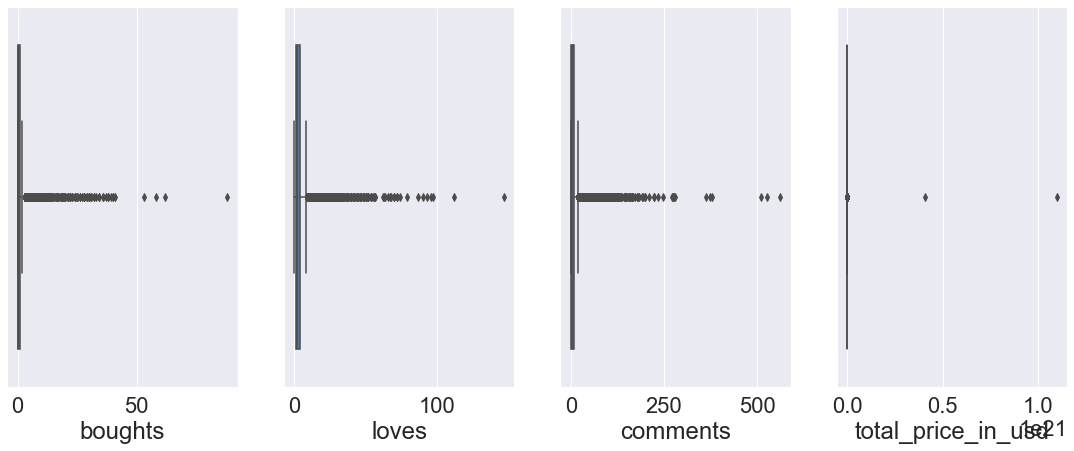

In [170]:
sns.set(font_scale=2)
fig = plt.figure(figsize=(12,12))
cols = ['boughts', 'loves', 'comments', 'total_price_in_usd']
fig, ax = plt.subplots(1,len(cols), figsize=(19,7))

print(len(cols))
for i in range(len(cols)):
   sns.boxplot(x=cols[i], data=df_paid_nonzero, whis=1.5,ax=ax[i])


In [171]:
df_paid_nonzero[['boughts', 'loves', 'comments', 'total_price_in_usd']].describe()

,boughts,loves,comments,total_price_in_usd
count,46078.000000,46078.000000,46078.000000,4.607800e+04
mean,0.557489,3.113416,7.132471,3.265937e+16
std,1.829810,4.517343,13.075260,5.460493e+18
min,0.000000,0.000000,0.000000,1.304348e-05
25%,0.000000,1.000000,1.000000,1.000000e+01
50%,0.000000,2.000000,4.000000,3.333333e+01
75%,1.000000,4.000000,8.000000,8.889722e+01
max,88.000000,147.000000,562.000000,1.100000e+21


In [190]:
def outlier_detection_iqr(df, numeric_cols, coeff=1.5):
    print(f'coeff in outlier detection: {coeff}')
    dfc = df.copy()
    for col in numeric_cols:    
        Q1 = numpy.percentile(df[col], 25)
        Q3 = numpy.percentile(df[col], 75)
        IQR = Q3 - Q1
        IQR_range = coeff * IQR
        col_outlier = df[(df[col] < Q1 - IQR_range) | 
                              (df[col] > Q3 + IQR_range )].index
        dfc.loc[col_outlier, col] = numpy.nan
    return dfc

In [188]:
def detect_and_drop_rows_with_outliers(df, cols, coeff=1.5):
    dfc = outlier_detection_iqr(df, cols, coeff)
    return dfc.dropna(subset = cols)

Some housekeeping for the user.blocked column

In [154]:
df_paid_nonzero['user.blocked'] = df_paid_nonzero['user.blocked'].fillna(0).astype(int)

<ipython-input-154-cb5f47227003>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paid_nonzero['user.blocked'] = df_paid_nonzero['user.blocked'].fillna(0).astype(int)


Looking at user rank distribution

<AxesSubplot:ylabel='user.rank'>

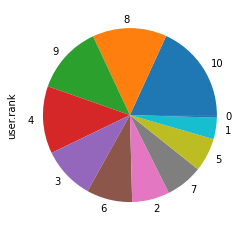

In [156]:
df_paid_nonzero['user.rank'].value_counts().plot(kind='pie')

Let's see how loves/boughts/comments are distributed by user rank

3


<Figure size 432x288 with 0 Axes>

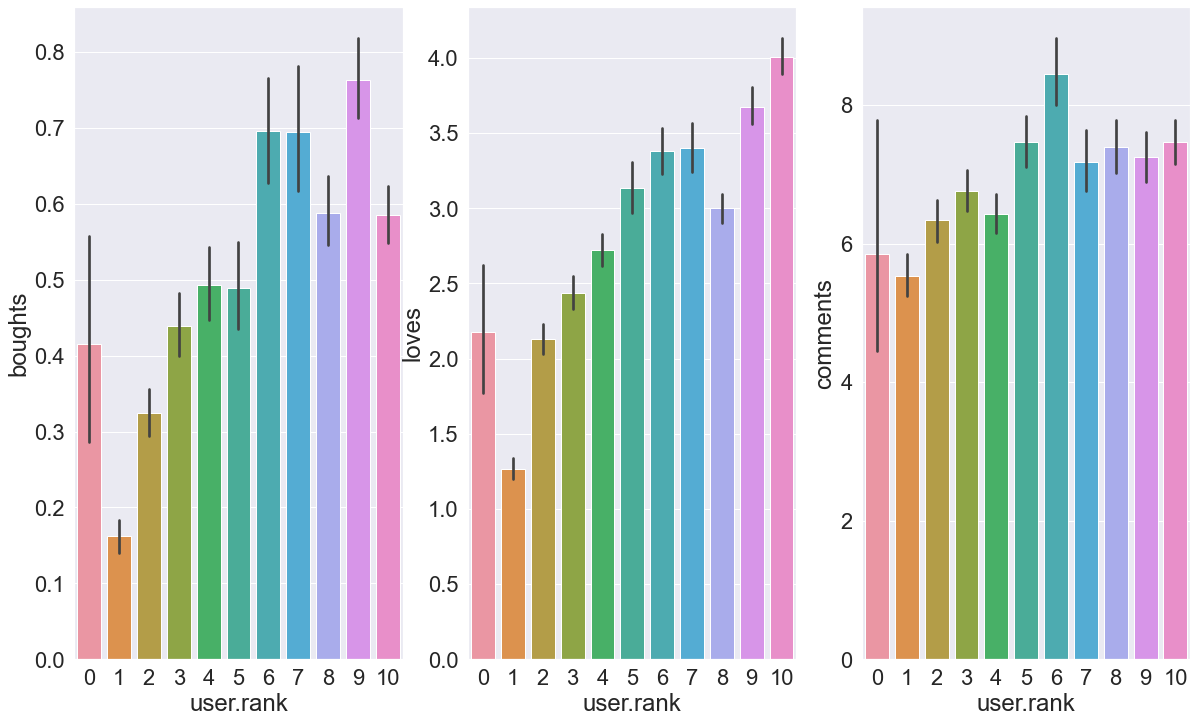

In [166]:
sns.set(font_scale=2)
fig = plt.figure()
cols = ['boughts', 'loves', 'comments']
fig, ax = plt.subplots(1,len(cols), figsize=(20,12))

print(len(cols))
for i in range(len(cols)):
   sns.barplot(x='user.rank', y=cols[i], data=df_paid_nonzero, ax=ax[i])

3


<Figure size 432x288 with 0 Axes>

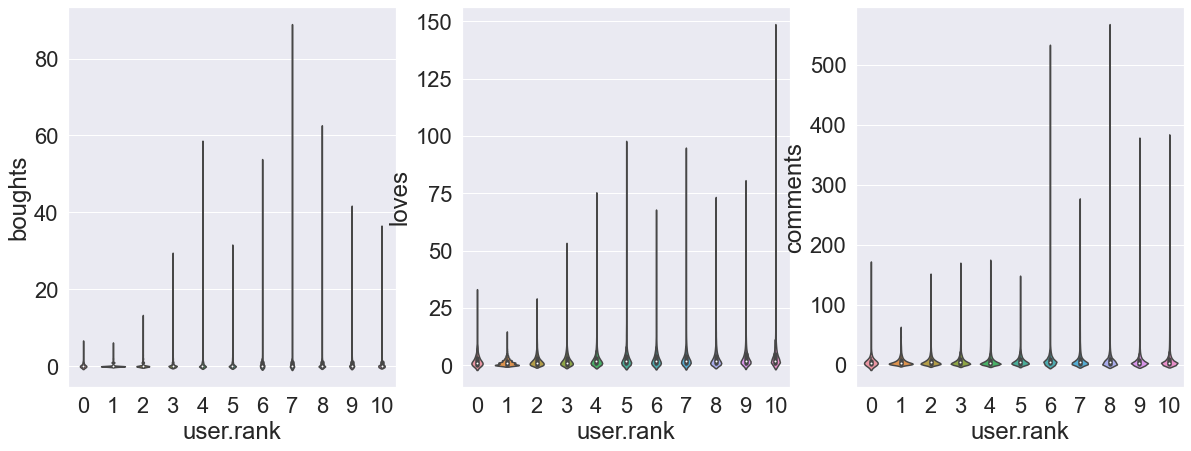

In [172]:
fig = plt.figure()
cols = ['boughts', 'loves', 'comments']
fig, ax = plt.subplots(1,len(cols), figsize=(20,7))

print(len(cols))
for i in range(len(cols)):
   sns.violinplot(x='user.rank', y=cols[i], data=df_paid_nonzero, ax=ax[i])

KDE plot for boughts/loves/comments - very dense near zero

3


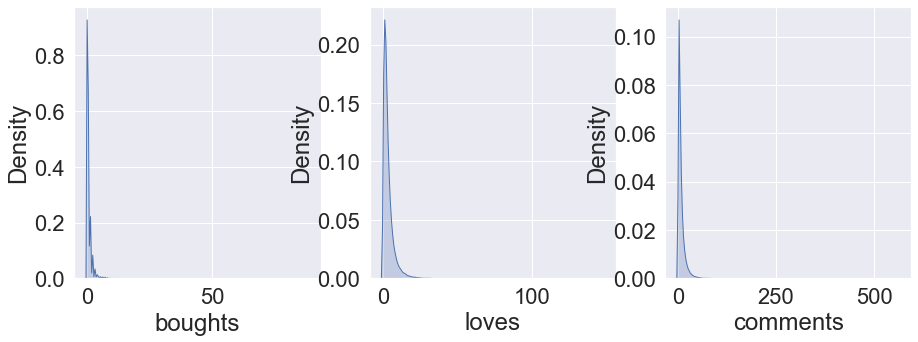

In [185]:
cols = ['boughts', 'loves', 'comments']
fig, ax = plt.subplots(1,len(cols), figsize=(15,5))

print(len(cols))
for i in range(len(cols)):
   sns.kdeplot(x=cols[i], data=df_paid_nonzero, shade=True, ax=ax[i])


Some scatter plots to get a general idea of how things are distributed

array([[<AxesSubplot:xlabel='boughts', ylabel='boughts'>,
        <AxesSubplot:xlabel='loves', ylabel='boughts'>,
        <AxesSubplot:xlabel='comments', ylabel='boughts'>,
        <AxesSubplot:xlabel='total_price_in_usd', ylabel='boughts'>,
        <AxesSubplot:xlabel='user.rank', ylabel='boughts'>,
        <AxesSubplot:xlabel='desc_word_count', ylabel='boughts'>,
        <AxesSubplot:xlabel='imgs_count', ylabel='boughts'>,
        <AxesSubplot:xlabel='desc_sentiment_neg', ylabel='boughts'>,
        <AxesSubplot:xlabel='desc_sentiment_neu', ylabel='boughts'>,
        <AxesSubplot:xlabel='desc_sentiment_pos', ylabel='boughts'>,
        <AxesSubplot:xlabel='desc_sentiment_compound', ylabel='boughts'>,
        <AxesSubplot:xlabel='free_shipping', ylabel='boughts'>,
        <AxesSubplot:xlabel='shipping_from_il', ylabel='boughts'>],
       [<AxesSubplot:xlabel='boughts', ylabel='loves'>,
        <AxesSubplot:xlabel='loves', ylabel='loves'>,
        <AxesSubplot:xlabel='comments', ylabel='

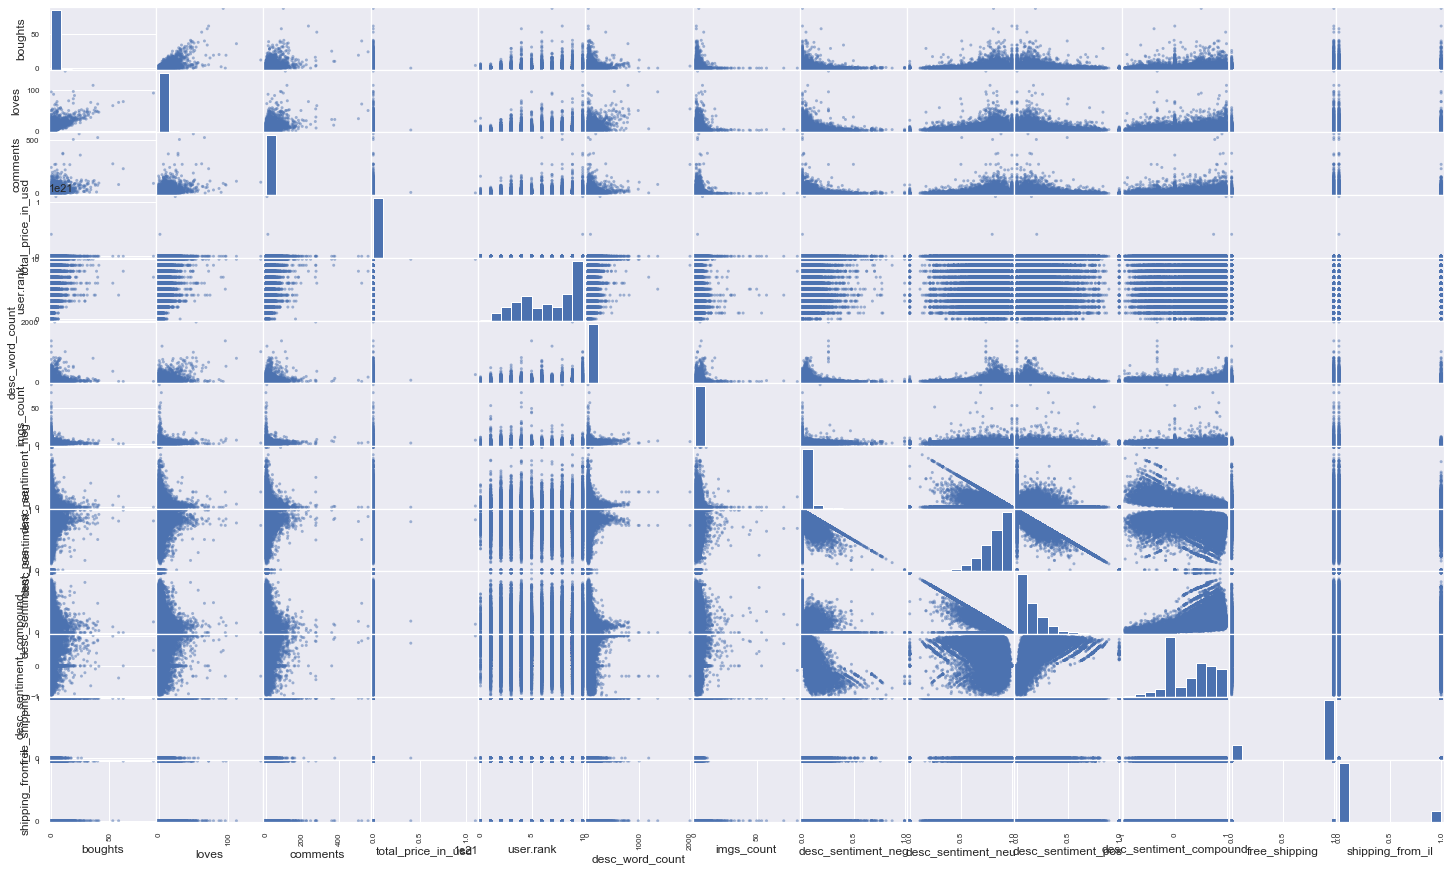

In [179]:
sns.set(font_scale=1)
pd.plotting.scatter_matrix(df_paid_nonzero[['boughts','loves','comments', 'total_price_in_usd', 'user.rank', 'desc_word_count', 'imgs_count', "desc_sentiment_neg",  "desc_sentiment_neu",  "desc_sentiment_pos",  "desc_sentiment_compound", "free_shipping", 'shipping_from_il']], figsize=(25,15))

array([[<AxesSubplot:xlabel='boughts', ylabel='boughts'>,
        <AxesSubplot:xlabel='loves', ylabel='boughts'>,
        <AxesSubplot:xlabel='comments', ylabel='boughts'>],
       [<AxesSubplot:xlabel='boughts', ylabel='loves'>,
        <AxesSubplot:xlabel='loves', ylabel='loves'>,
        <AxesSubplot:xlabel='comments', ylabel='loves'>],
       [<AxesSubplot:xlabel='boughts', ylabel='comments'>,
        <AxesSubplot:xlabel='loves', ylabel='comments'>,
        <AxesSubplot:xlabel='comments', ylabel='comments'>]], dtype=object)

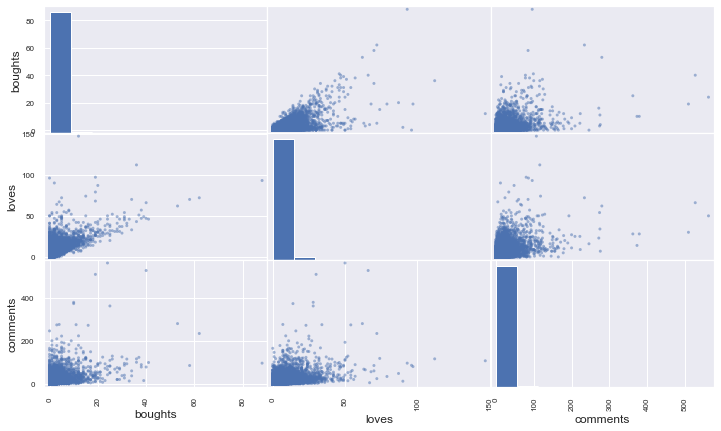

In [178]:
pd.plotting.scatter_matrix(df_paid_nonzero[['boughts','loves','comments']], figsize=(12,7))

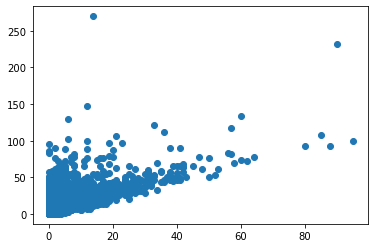

In [134]:
plt.scatter(dfc.boughts, dfc.loves)

Correlation matrix with pretty colors - also exportable to Excel for freezing panes

In [181]:
def b_g(df, cmap='PuBu', low=0, high=0):
    # Pass the columns from Dataframe A 
    rng = df.abs().max() - df.abs().min()
    norm = colors.Normalize(df.abs().min() - (rng * low),
                        df.abs().max() + (rng * high))
    normed = norm(df.abs().values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df_paid_nonzero.corr().style.apply(b_g,cmap='PuBu').to_excel('df_paid_nonzero_styled1.xlsx', engine='openpyxl')#freezing header rows/columns is more convenient in Excel...
df_paid_nonzero.corr().style.apply(b_g,cmap='PuBu')#display inline

,user.follows,user.deals_count,user.loves_count,user.rep,user.rank,user.blocked,user.isAdmin,loves,unloves,boughts,comments,clicks,impressions,desc_word_count,imgs_count,desc_sentiment_neg,desc_sentiment_neu,desc_sentiment_pos,desc_sentiment_compound,free_shipping,shipping_from_il,price_in_usd,shipping_price_in_usd,total_price_in_usd,title_word_count
user.follows,1.000000,0.158750,0.259929,0.337381,0.077659,-0.001516,0.219042,0.017024,-0.005482,-0.000888,-0.004184,-0.004568,-0.017007,0.009301,-0.021736,-0.006305,0.015028,-0.012846,0.004379,0.013003,0.103446,-0.000416,-0.000472,-0.000428,-0.003421
user.deals_count,0.158750,1.000000,0.507936,0.873820,0.640380,-0.011145,0.607739,-0.030935,-0.012343,-0.042814,-0.053116,-0.018414,-0.073749,-0.064435,-0.017196,-0.012105,0.044049,-0.039900,-0.073249,-0.211820,-0.092135,0.000198,0.000224,0.000204,0.110250
user.loves_count,0.259929,0.507936,1.000000,0.487100,0.508520,-0.010688,0.070662,0.047365,-0.023609,0.017028,-0.015418,-0.026079,-0.048233,0.089733,0.001537,0.004057,0.064672,-0.068053,-0.032419,-0.190488,-0.035696,-0.000518,-0.000587,-0.000533,0.152095
user.rep,0.337381,0.873820,0.487100,1.000000,0.679842,-0.012111,0.697261,0.073610,-0.015757,0.008326,0.011208,0.021511,-0.019475,0.004562,0.004831,-0.001216,0.046710,-0.047646,-0.044699,-0.183038,-0.051091,0.004942,0.005600,0.005084,0.105391
user.rank,0.077659,0.640380,0.508520,0.679842,1.000000,-0.041075,0.289090,0.139443,-0.017599,0.060699,0.031980,0.023236,0.004939,0.043805,-0.007011,-0.005946,0.081453,-0.081976,-0.054715,-0.174440,-0.054790,0.007399,0.008384,0.007611,0.156035
user.blocked,-0.001516,-0.011145,-0.010688,-0.012111,-0.041075,1.000000,-0.004495,-0.009235,-0.001840,-0.005042,0.001860,0.000155,-0.005254,-0.002732,-0.002686,-0.002318,-0.010056,0.011532,0.007751,0.009146,-0.004879,-0.000108,-0.000123,-0.000111,-0.002131
user.isAdmin,0.219042,0.607739,0.070662,0.697261,0.289090,-0.004495,1.000000,0.007184,-0.009913,-0.018243,0.015172,0.033572,0.003710,-0.044484,0.031778,-0.002874,0.015631,-0.014157,-0.036035,-0.114770,0.006348,-0.001402,-0.001589,-0.001442,0.028165
loves,0.017024,-0.030935,0.047365,0.073610,0.139443,-0.009235,0.007184,1.000000,0.001344,0.641420,0.454822,0.314781,0.385737,0.319401,0.014733,0.013973,0.014557,-0.021811,0.058899,0.031138,0.047059,0.020269,0.014419,0.019818,0.011220
unloves,-0.005482,-0.012343,-0.023609,-0.015757,-0.017599,-0.001840,-0.009913,0.001344,1.000000,0.007385,0.043671,0.013496,0.032860,-0.005586,-0.008504,0.000173,-0.022229,0.023556,0.001956,0.016256,-0.005937,-0.000574,-0.000651,-0.000591,0.002277
boughts,-0.000888,-0.042814,0.017028,0.008326,0.060699,-0.005042,-0.018243,0.641420,0.007385,1.000000,0.450447,0.307889,0.309360,0.115536,0.007714,0.004639,0.011047,-0.014841,0.028591,0.052770,0.045107,0.007970,0.005194,0.007735,0.034265


<AxesSubplot:>

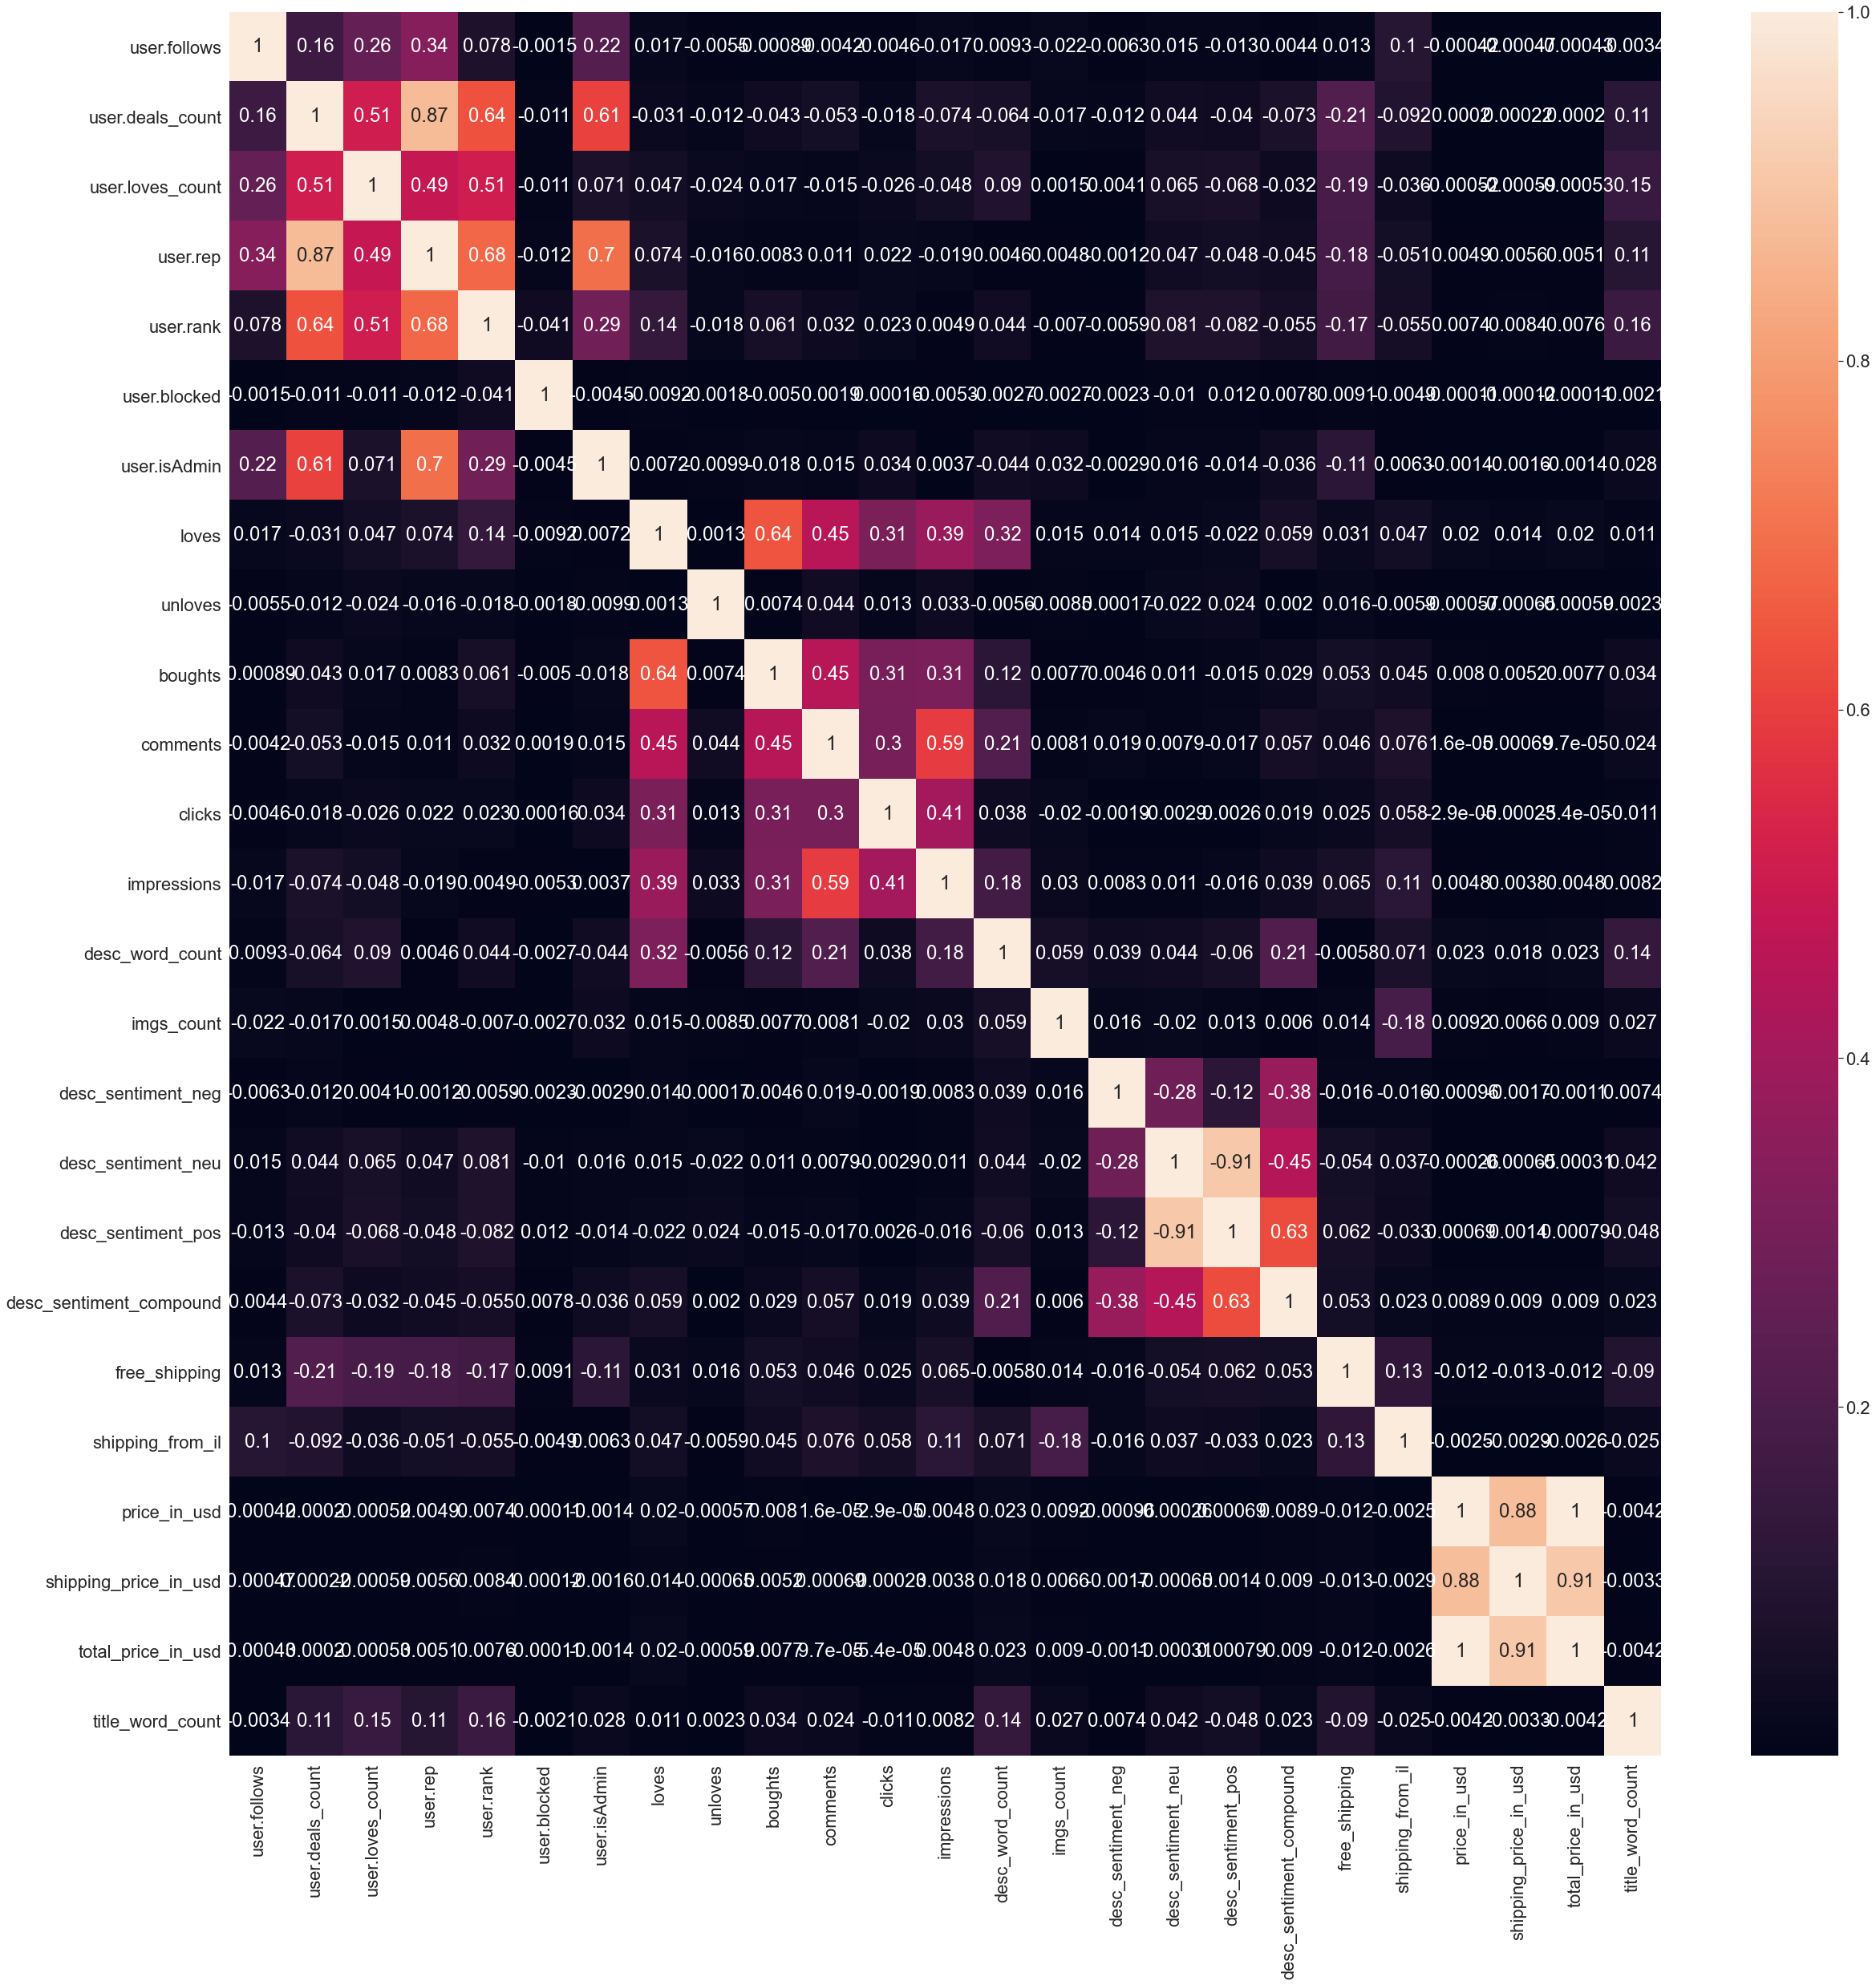

In [183]:
sns.set(font_scale=2)
fig,ax = plt.subplots(figsize=(40,40))
sns.heatmap(df_paid_nonzero.corr().abs(), ax=ax, annot=df_paid_nonzero.corr())

Starting with linear regression

In [195]:
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.linear_model import LinearRegression


In [196]:
def normalize_all_values(df):
    print('normalizing!')
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled,columns=df.columns)

In [226]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, pipeline

Functions that allow us to set the target column and run the regression with/without dropping other target columns, and with/without Polynomial Features, and show metrics and most important features

In [232]:
def lin_reg_for_col(df, col, dropAllTargetColumns=False, model=linear_model.LinearRegression()):
    y = df[col]
    if dropAllTargetColumns:
        df = df.drop(['loves', 'unloves', 'boughts', 'comments', 'clicks', 'impressions'], axis=1)
    X = df.loc[:, df.columns != col]
    xtrain,xtest,ytrain,ytest = train_test_split(X, y, random_state=0, test_size=0.2)
    model.fit(xtrain,ytrain)
    y_pred=model.predict(xtest)
    print(f"for column {col}:")
    print(f"mse: {metrics.mean_squared_error(ytest,y_pred )} ")
    r2 = metrics.r2_score(ytest,y_pred )
    print(f"r^2: {r2} ")
    for k,v in sorted(dict (zip (X.columns, (model.named_steps['linearregression'].coef_))).items(), key=lambda x:x[1], reverse=True) :
       print (f"  {k}",v)
    return r2

In [251]:
def show_regression(df, norm=False, dropAllTargetColumns=False, polyFeatures=False):
    if polyFeatures:
        model = pipeline.make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression())  
    else:
        model = pipeline.make_pipeline(linear_model.LinearRegression())
    dict = {'dropAllTargetColumns': dropAllTargetColumns, 'PolynomialFeatures': polyFeatures}
    dfc = df.copy()
    if (norm):
       dfc=normalize_all_values(dfc)
    for col in ['loves', 'boughts', 'comments', 'clicks', 'impressions']:
        r2 = lin_reg_for_col(dfc, col, dropAllTargetColumns, model)
        dict[col] = r2
    return dict

Checking - which IQR coefficient gives best regression results:

In [221]:
coeffs=[0.5, 1, 1.5,2,3,4,5,6,7,8,9]
for coeff in coeffs:
    print(f'coeff: {coeff}')
    df_paid_nonzero_no_outliers = detect_and_drop_rows_with_outliers(df_paid_nonzero, ['total_price_in_usd', 'price_in_usd', 'shipping_price_in_usd'], coeff)
    show_regression(df_paid_nonzero_no_outliers, norm=True, dropAllTargetColumns=True)

coeff: 0.5
coeff in outlier detection: 0.5
normalizing!
for column loves:
mse: 0.0009446696016824116 
r^2: 0.14807820972704477 
  desc_word_count 0.3859273303597815
  user.rep 0.06988332271813719
  user.rank 0.018852837001150854
  desc_sentiment_pos 0.014761132228500493
  desc_sentiment_neu 0.012703911243681682
  desc_sentiment_neg 0.005167958810136059
  shipping_from_il 0.0035787760984778727
  user.loves_count 0.0008002066051603924
  user.blocked 0.00027301647537817113
  shipping_price_in_usd 0.0
  free_shipping -8.673617379884035e-18
  imgs_count -0.0031768030288987855
  user.isAdmin -0.003933351873902224
  desc_sentiment_compound -0.004234382653540799
  total_price_in_usd -0.0073796780673050484
  price_in_usd -0.007379678067305108
  user.follows -0.021897490210058494
  title_word_count -0.030720097678477696
  user.deals_count -0.04061380307356537
for column unloves:
mse: 0.001431372065987224 
r^2: -0.0016946321411761556 
  desc_sentiment_pos 0.01511508500186501
  user.rep 0.00762105

for column loves:
mse: 0.0007505036862323313 
r^2: 0.14020228374237642 
  desc_word_count 0.3697015007536009
  user.rep 0.07054313579969847
  user.rank 0.019196799868817317
  desc_sentiment_pos 0.013065930838834837
  desc_sentiment_neu 0.011509192241378226
  desc_sentiment_neg 0.0076919083041876645
  shipping_from_il 0.0031912266761877518
  shipping_price_in_usd 0.0
  free_shipping -6.938893903907228e-18
  user.loves_count -0.00021379644331836483
  desc_sentiment_compound -0.0024667266589548063
  user.blocked -0.0035148654065459512
  user.isAdmin -0.004139658306072613
  imgs_count -0.005992562320355569
  total_price_in_usd -0.0096747930054862
  price_in_usd -0.00967479300548627
  user.follows -0.027254464037575744
  title_word_count -0.03200248902025314
  user.deals_count -0.039152976179640545
for column unloves:
mse: 0.0009018636375951359 
r^2: 0.0004946382129473736 
  desc_word_count 0.012400883455492406
  desc_sentiment_pos 0.01186645295942903
  desc_sentiment_neu 0.0067741207291129

for column clicks:
mse: 2.1873297565453955e-05 
r^2: 0.030442369488289045 
  user.rep 0.007116831623293157
  desc_word_count 0.006691065116335684
  desc_sentiment_neu 0.0025281655568199467
  desc_sentiment_neg 0.0024906272068900837
  desc_sentiment_pos 0.0021569695854192048
  user.blocked 0.0014401045511085173
  shipping_from_il 0.0013686655604651632
  user.rank 0.0012604349746167267
  user.isAdmin 0.0012158050900091429
  desc_sentiment_compound 0.0008607898335965603
  shipping_price_in_usd 0.0
  free_shipping -4.336808689942018e-19
  price_in_usd -0.0005627365081935151
  total_price_in_usd -0.0005627365081935282
  user.loves_count -0.0008787737358565636
  title_word_count -0.003410841093615886
  user.deals_count -0.004083654109519471
  user.follows -0.005417291570586127
  imgs_count -0.007393736602131831
for column impressions:
mse: 0.0006733792697463357 
r^2: 0.05039971081070904 
  desc_word_count 0.139969851843278
  user.rep 0.026025814704562653
  imgs_count 0.02499126142778672
  de

normalizing!
for column loves:
mse: 0.0008709630366513456 
r^2: 0.21036788317780986 
  desc_word_count 0.449792484399392
  user.rep 0.0705946612469079
  user.rank 0.018341013167323776
  desc_sentiment_pos 0.010631136151203362
  desc_sentiment_neu 0.010045390006140202
  desc_sentiment_neg 0.007847092421952553
  shipping_from_il 0.002529920721556183
  user.loves_count 0.0007594474157494734
  free_shipping 5.551115123125783e-17
  shipping_price_in_usd 0.0
  desc_sentiment_compound -0.0006012659329186358
  user.isAdmin -0.0036929892855327097
  user.blocked -0.0038312455141093554
  imgs_count -0.00720929481914134
  total_price_in_usd -0.01092864639119649
  price_in_usd -0.010928646391197052
  user.follows -0.026222659440093117
  title_word_count -0.030410422278860472
  user.deals_count -0.040341206643615936
for column unloves:
mse: 0.0012032666580149383 
r^2: 2.396092416545592e-05 
  desc_word_count 0.015435811902542045
  desc_sentiment_pos 0.011381617257531907
  desc_sentiment_neu 0.005892

for column unloves:
mse: 0.0010173100012263127 
r^2: 0.00031506241757528475 
  desc_sentiment_pos 0.012753840461128055
  desc_sentiment_neu 0.005886153831817204
  title_word_count 0.0033035845389187005
  desc_sentiment_neg 0.0032749983803791
  user.rep 0.003216971380435863
  desc_word_count 0.0030390268220888096
  price_in_usd 0.00012478800603575233
  total_price_in_usd 0.00012478800603573026
  free_shipping 2.168404344971009e-18
  shipping_price_in_usd 0.0
  user.deals_count -0.00017814263162540544
  user.isAdmin -0.0009454267156755173
  shipping_from_il -0.0009676982828972357
  user.follows -0.0010501494726771828
  user.rank -0.0015262215534416798
  user.loves_count -0.0027215655103560625
  desc_sentiment_compound -0.0036346927280790794
  user.blocked -0.004656336240188729
  imgs_count -0.013464349614501755
for column boughts:
mse: 0.00041452750087106526 
r^2: 0.03207210641913627 
  desc_word_count 0.10336326641635209
  user.rep 0.019133439670727365
  title_word_count 0.0143392412460

Best coefficient is 5. We'll use that and run some comparisons

In [252]:
reg_results = []
for dropAllTargetColumns in [True, False]:
    for polyFeatures in [True, False]:
        reg_results.append(show_regression(detect_and_drop_rows_with_outliers(df_paid_nonzero, ['total_price_in_usd', 'price_in_usd', 'shipping_price_in_usd'], coeff=5), norm=False, dropAllTargetColumns=dropAllTargetColumns, polyFeatures=polyFeatures))

coeff in outlier detection: 5
for column loves:
mse: 19.752518016775213 
r^2: 0.2844664606317667 
  desc_sentiment_compound 1287.2863981863197
  desc_sentiment_neu 425.04400522194874
  free_shipping 66.73862237028287
  price_in_usd 1.3277018530963909
  user.blocked 0.6440919838877679
  desc_sentiment_neg 0.2521862068747684
  user.deals_count 0.019603346293599392
  user.rank 0.0023103193213647724
  user.rep 0.0019983050769988566
  user.follows 0.0015083200369306177
  total_price_in_usd 1.283124627623141e-05
  shipping_from_il -1.1645755621089961e-05
  title_word_count -0.003081272372087102
  shipping_price_in_usd -0.003091583255813887
  desc_word_count -0.0110334025643635
  user.loves_count -0.01809291998181695
  imgs_count -0.03890896238793412
  user.isAdmin -0.057205783065756896
  desc_sentiment_pos -203.56698558164513
for column boughts:
mse: 4.801879698304377 
r^2: 0.05728177509353394 
  desc_sentiment_neu 466.3220927525112
  free_shipping 139.6307383932441
  desc_sentiment_compound

for column boughts:
mse: 1.8318966570916442 
r^2: 0.6403570115687525 
  desc_sentiment_neu 301.88450618116775
  free_shipping 78.27033582534676
  unloves 0.1510078809904239
  desc_sentiment_neg 0.123132262007768
  price_in_usd 0.07288891691875761
  user.follows 0.0031139227723063732
  loves 0.002985964400183827
  imgs_count 0.0017764739080351499
  user.deals_count 0.0015026302636076754
  desc_word_count 0.0003123084014740765
  user.rank 0.0002995398583933195
  user.rep 5.36791026028633e-05
  shipping_from_il 1.910247329421588e-05
  total_price_in_usd -5.68201069726032e-05
  title_word_count -0.0008566021127596802
  shipping_price_in_usd -0.0008659383912021979
  user.loves_count -0.0009142985676512539
  impressions -0.005410980378942502
  user.isAdmin -0.012616888400851355
  clicks -0.019905009668760104
  user.blocked -0.15849044778854676
  desc_sentiment_pos -9.31622453529208
  comments -20.386102393468217
  desc_sentiment_compound -274.0130054183571
for column comments:
mse: 101.71996

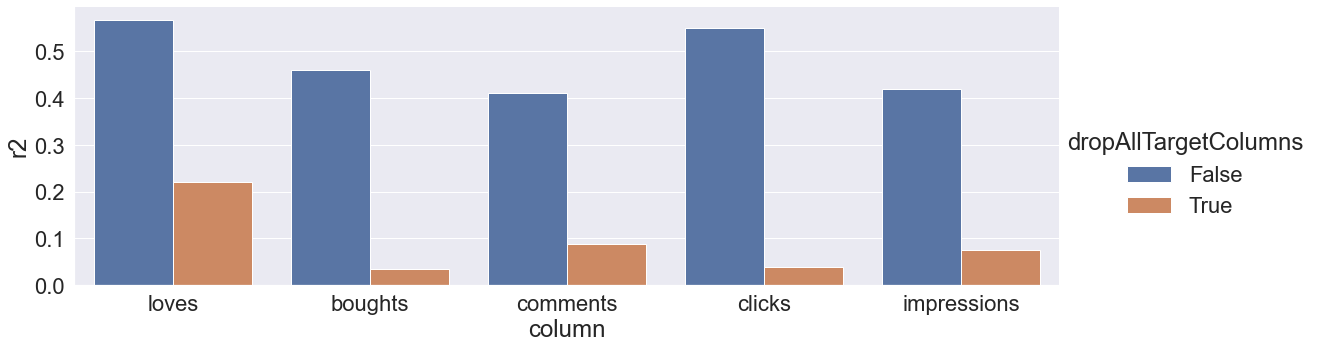

In [258]:
reg_res_df=pd.DataFrame(reg_results)
reg_res_drop_cols = reg_res_df.loc[reg_res_df["PolynomialFeatures"] == False].drop(["PolynomialFeatures"], axis=1)
reg_res_drop_cols = pd.melt(reg_res_drop_cols, id_vars="dropAllTargetColumns", var_name="column", value_name="r2")
sns.catplot(x='column', y='r2', hue='dropAllTargetColumns', data=reg_res_drop_cols, kind='bar', height=5, aspect=3)


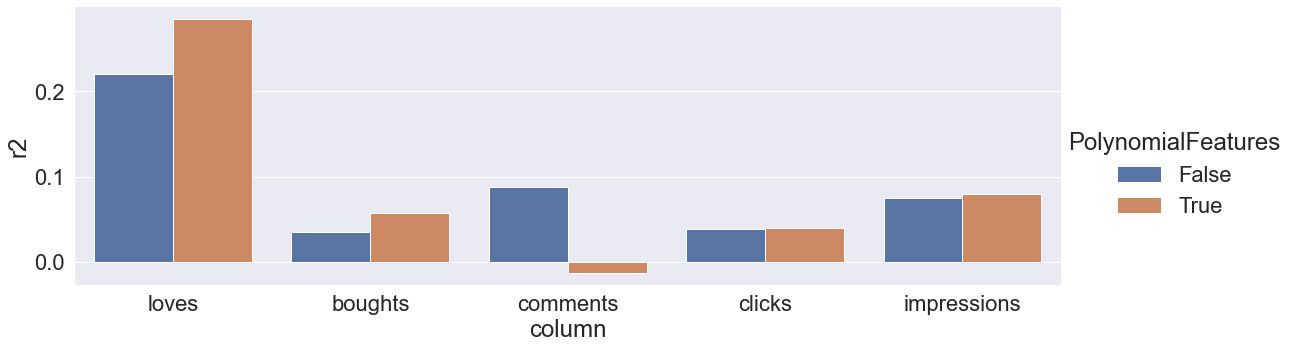

In [259]:
reg_res_poly = reg_res_df.loc[reg_res_df["dropAllTargetColumns"] == True].drop(["dropAllTargetColumns"], axis=1)

reg_res_poly = pd.melt(reg_res_poly, id_vars="PolynomialFeatures", var_name="column", value_name="r2")

sns.catplot(x='column', y='r2', hue='PolynomialFeatures', data=reg_res_poly, kind='bar', height=5, aspect=3)


KNN - remove outliers, normalize dataset, find best values for hyper-parameters

In [804]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [261]:
dfkn = detect_and_drop_rows_with_outliers(df_paid_nonzero, ['total_price_in_usd', 'price_in_usd', 'shipping_price_in_usd'])
dfkn=normalize_all_values(dfkn)

X = dfkn.drop(['boughts', 'loves', 'comments', 'impressions', 'clicks'], axis=1)
y = dfkn['loves']
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.2)

coeff in outlier detection: 1.5
normalizing!


In [805]:
parameters = {'n_neighbors':range(1,25,2) }
knn = KNeighborsRegressor()
clf = GridSearchCV(knn, parameters,scoring=make_scorer(metrics.r2_score, greater_is_better=True))
clf.fit(XTrain, yTrain)
print("best parameter set is:",clf.best_params_," and its score was",clf.best_score_)


best parameter set is: {'n_neighbors': 23}  and its score was 0.12671352715231946


In [815]:
k_s=[]

train_accuracies=[]
test_accuracies=[]
for k in [5, 55, 105, 155, 205]:
    clf = KNeighborsRegressor(n_neighbors=k)
    clf.fit(XTrain, yTrain)
    y_pred_train=clf.predict(XTrain)
    y_pred=clf.predict(XTest)
    k_s.append(k)
    train_accuracies.append(metrics.r2_score(y_true = yTrain, y_pred = y_pred_train))
    test_accuracies.append(metrics.r2_score(y_true = yTest, y_pred = y_pred))

df=pd.DataFrame({"k":k_s,"train_accuracy":train_accuracies,"test_accuracy":test_accuracies})
df

,k,train_accuracy,test_accuracy
0,5,0.372874,0.091036
1,55,0.156764,0.134211
2,105,0.128784,0.116161
3,155,0.113747,0.106568
4,205,0.105498,0.099774


In [817]:
k_s=[]

train_accuracies=[]
test_accuracies=[]
for k in range(15,105,10):
    clf = KNeighborsRegressor(n_neighbors=k)
    clf.fit(XTrain, yTrain)
    y_pred_train=clf.predict(XTrain)
    y_pred=clf.predict(XTest)
    k_s.append(k)
    train_accuracies.append(metrics.r2_score(y_true = yTrain, y_pred = y_pred_train))
    test_accuracies.append(metrics.r2_score(y_true = yTest, y_pred = y_pred))

df=pd.DataFrame({"k":k_s,"train_accuracy":train_accuracies,"test_accuracy":test_accuracies})
df

,k,train_accuracy,test_accuracy
0,15,0.246684,0.141637
1,25,0.207639,0.149222
2,35,0.185317,0.141091
3,45,0.168766,0.137353
4,55,0.156764,0.134211
5,65,0.148385,0.129289
6,75,0.142952,0.123760
7,85,0.136784,0.120755
8,95,0.132423,0.118573


In [818]:
dfkn.to_pickle('df_for_ml.pkl')

Continued in project - cont.ipynb